In [1]:
import numpy as np

def grad_U(Ui, Yij, Vj, reg, eta):
    """
    Takes as input Ui (the ith row of U), a training point Yij, the column
    vector Vj (jth column of V^T), reg (the regularization parameter lambda),
    and eta (the learning rate).

    Returns the gradient of the regularized loss function with
    respect to Ui multiplied by eta.
    """
    return eta * (reg * Ui - Yij * Vj + Ui.dot(Vj) * Vj)

def grad_V(Vj, Yij, Ui, reg, eta):
    """
    Takes as input the column vector Vj (jth column of V^T), a training point Yij,
    Ui (the ith row of U), reg (the regularization parameter lambda),
    and eta (the learning rate).

    Returns the gradient of the regularized loss function with
    respect to Vj multiplied by eta.
    """
    return eta * (reg * Vj - Yij * Ui + Ui.dot(Vj) * Ui)

def grad_bias(Vj, Yij, Ui, eta, ai, bj):
    """
    Takes as input the column vector Vj (jth column of V^T), a training point Yij,
    Ui (the ith row of U), reg (the regularization parameter lambda),
    and eta (the learning rate), and bias entries ai, bj.

    Returns the gradient of the regularized loss function with
    respect to bias multiplied by learning rate.
    """
    return -eta * (Yij - (Ui.dot(Vj) + ai + bj))

def get_err(U, V, Y, reg=0.0):
    """
    Takes as input a matrix Y of triples (i, j, Y_ij) where i is the index of a user,
    j is the index of a movie, and Y_ij is user i's rating of movie j and
    user/movie matrices U and V.

    Returns the mean regularized squared-error of predictions made by
    estimating Y_{ij} as the dot product of the ith row of U and the jth column of V^T.
    """
    sum_u = np.linalg.norm(U, ord = 'fro') ** 2
    sum_v = np.linalg.norm(V, ord = 'fro') ** 2
    sum_err = 0
    for i, j, rating in Y:
        i -= 1
        j -= 1
        sum_err += (rating - U[i, :].T.dot(V[j, :])) ** 2
    return reg / 2 * (sum_u + sum_v) + sum_err / 2

def get_err_bias(U, V, Y, a, b, reg = 0.0):
    sum_u = np.linalg.norm(U, ord = 'fro') ** 2
    sum_v = np.linalg.norm(V, ord = 'fro') ** 2
    sum_err = 0
    for i, j, rating in Y:
        i -= 1
        j -= 1
        if i >= U.shape[0] or j >= V.shape[0]:
            continue
        sum_err += (rating - U[i, :].T.dot(V[j, :]) - a[i] - b[j]) ** 2
    return reg / 2 * (sum_u + sum_v) + sum_err / 2

def get_err_shelf(shelf, U, V, Y):
    err = 0
    sum_u = np.linalg.norm(U, ord = 'fro') ** 2
    sum_v = np.linalg.norm(V, ord = 'fro') ** 2
    for i, j, rating in Y:
        err += (rating - shelf.predict(i, j, r_ui = rating).est) ** 2
    return reg / 2 * (sum_u + sum_v) + err / 2    

def train_model(M, N, K, eta, reg, Y, eps=0.0001, max_epochs=300, bias = False):
    """
    Given a training data matrix Y containing rows (i, j, Y_ij)
    where Y_ij is user i's rating on movie j, learns an
    M x K matrix U and N x K matrix V such that rating Y_ij is approximated
    by (UV^T)_ij.

    Uses a learning rate of <eta> and regularization of <reg>. Stops after
    <max_epochs> epochs, or once the magnitude of the decrease in regularized
    MSE between epochs is smaller than a fraction <eps> of the decrease in
    MSE after the first epoch.

    Returns a tuple (U, V, err) consisting of U, V, and the unregularized MSE
    of the model.
    """
    U = np.random.uniform(-0.5, 0.5, size = (M, K))
    V = np.random.uniform(-0.5, 0.5, size = (N, K))
    if bias:
        a = np.random.uniform(-0.5, 0.5, size = (M, ))
        b = np.random.uniform(-0.5, 0.5, size = (N, ))
    first_reduction = 0
    for k in range(max_epochs):
        if bias:
            curr_err = get_err_bias(U, V, Y, a, b, reg)
        else:
            curr_err = get_err(U, V, Y, reg)
        for i, j, rating in np.random.permutation(Y):
            i -= 1
            j -= 1
            Ui = np.copy(U[i, :])
            Vj = np.copy(V[j, :])
            U[i, :] -= grad_U(Ui, rating, Vj, reg, eta)
            V[j, :] -= grad_V(Vj, rating, Ui, reg, eta)
            if bias:
                ai = a[i]
                bj = b[j]
                change = grad_bias(Vj, rating, Ui, eta, ai, bj)
                a[i] -= change
                b[j] -= change
        if bias:
            next_err = get_err_bias(U, V, Y, a, b, reg)
        else:
            next_err = get_err(U, V, Y, reg)
        if k == 0:
            first_reduction = curr_err - next_err
        else:
            if (curr_err - next_err) / first_reduction <= eps:
                break
    if bias:
        return (U, V, next_err, a, b)
    else:
        return (U, V, next_err)

In [2]:
Y_train = np.loadtxt('data/train.txt').astype(int)
Y_test = np.loadtxt('data/test.txt').astype(int)

M = max(max(Y_train[:,0]), max(Y_test[:,0])).astype(int) # users
N = max(max(Y_train[:,1]), max(Y_test[:,1])).astype(int) # movies
print("Factorizing with ", M, " users, ", N, " movies.")
K = 20

reg = 0.0
eta = 0.03 # learning rate

U,V, err = train_model(M, N, K, eta, reg, Y_train)
E_in_no_bias = err
E_out_no_bias = get_err(U, V, Y_test)

Factorizing with  943  users,  1682  movies.


In [3]:
print(E_in_no_bias)
print(E_out_no_bias)

17014.848132306397
6106.949287751425


In [83]:
U, V, err, a, b = train_model(M, N, K, eta, reg, Y_train, bias = True)
E_in_bias = err
E_out_bias = get_err_bias(U, V, Y_test, a, b)

In [26]:
print(E_in_bias)
print(E_out_bias)

20619.96676035208
5831.907188074287


In [65]:
from surprise import SVD, Reader, Dataset
import pandas as pd
shelf = SVD(n_factors = K, n_epochs = 300, lr_all = eta, reg_all = 0)
df = pd.DataFrame({'userID': Y_train[:, 0], 'movieID': Y_train[:, 1], 'rating': Y_train[:, 2]})
reader = Reader(rating_scale = (1, 5))
data = Dataset.load_from_df(df[['userID', 'movieID', 'rating']], reader)
trainset = data.build_full_trainset()
shelf.fit(trainset)
E_in_shelf = get_err_shelf(shelf, shelf.pu, shelf.qi, Y_train)
E_out_shelf = get_err_shelf(shelf, shelf.pu, shelf.qi, Y_test)

In [66]:
print(E_in_shelf)
print(E_out_shelf)

11481.332718708025
7201.574500752578


# 2D visualization

In [84]:
V_ = np.copy(V)
U_ = np.copy(U)

In [102]:
V = np.copy(V_)
U = np.copy(U_)

In [95]:
#mean centering V
means = V.mean(axis = 0)
V -= means

#shift U by same amount
U -= means

In [103]:
A, Sig, B = np.linalg.svd(V.T, full_matrices=False)

In [104]:
V_proj = A[:,:2].T.dot(V.T)
U_proj = A[:,:2].T.dot(U.T)

In [99]:
# #rescaling so that each row of U_proj and V_proj has unit variance
# from sklearn import preprocessing

# V_proj = preprocessing.scale(V_proj)
# U_proj = preprocessing.scale(U_proj)

#Doesn't work!!

In [114]:
import matplotlib.pyplot as plt
import random
import csv

with open("data/movies.txt", encoding="latin_1") as f:
    reader = csv.reader(f, delimiter="\t")
    
    # Put the contents in a matrix
    movies = np.array(list(reader))

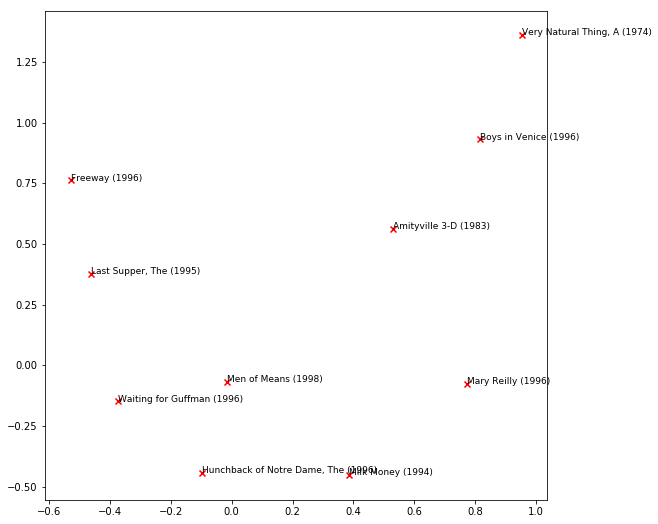

In [141]:
import matplotlib.pyplot as plt
import random

mov_i = random.sample(range(0, 1682), 10)
names = movies[:,1][mov_i]
plt.figure(figsize=(9,9))
for idx, i in enumerate(mov_i):
    x = V_proj[0,:][i]
    y = V_proj[1,:][i]
    plt.scatter(x, y, marker='x', color='red')
    plt.text(x, y, names[idx], fontsize=9)
plt.show()

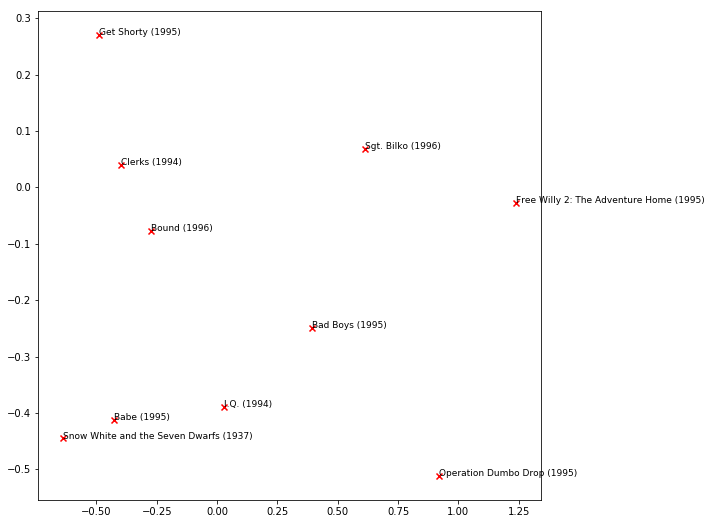

In [151]:
# Find Adventure Movies 5th column
IDs = []
for i, line in enumerate(movies):
    if int(line[4]):
        IDs.append(i)
mov_i = random.sample(range(0, len(IDs)), 10)

names = movies[:,1][mov_i]
plt.figure(figsize=(9,9))
for idx, i in enumerate(mov_i):
    x = V_proj[0,:][i]
    y = V_proj[1,:][i]
    plt.scatter(x, y, marker='x', color='red')
    plt.text(x, y, names[idx], fontsize=9)
plt.show()